### Detector Calibration procedures
Notebook demonstrating few approaches to detect some abnoramlities in detector data

In [1]:
from scipp import array, DataArray, ones_like
import h5py, os
import matplotlib.pyplot as plt

In [2]:
#Imports required for clustering algorithm
from sklearn.cluster import DBSCAN, KMeans, OPTICS
from sklearn import metrics
import numpy as np

In [3]:
# Convert Ring and FEN to numbers or if not set, to 'any'
def id2chr(id):
    if id == -1:
        return 'any'
    else:
        return f'{id}'

In [4]:
# Read EFU H5 file into scipp data structure. Adding positions and straw (as
# float values) calculated from the four amplitudes A,B,D and D to the structure
def readtoscipp(filename):

    f = h5py.File(filename, 'r')
    dat = f['loki_readouts']

    tube = array(values=dat['TubeId'].astype('int'), dims=['event'])
    ring = array(values=dat['RingId'].astype('int'), dims=['event'])
    fen = array(values=dat['FENId'].astype('int'), dims=['event'])

    ampl_a = array(values=1.0 * dat['AmpA'].astype('int'), dims=['event'], unit='mV')
    ampl_b = array(values=1.0 * dat['AmpB'].astype('int'), dims=['event'], unit='mV')
    ampl_c = array(values=1.0 * dat['AmpC'].astype('int'), dims=['event'], unit='mV')
    ampl_d = array(values=1.0 * dat['AmpD'].astype('int'), dims=['event'], unit='mV')

    events = ones_like(1. * tube)
    events.unit = 'counts'

    pos = (ampl_a + ampl_b) / (ampl_a + ampl_b + ampl_c + ampl_d)
    straw = (ampl_b + ampl_d) / (ampl_a + ampl_b + ampl_c + ampl_d)

    return DataArray(data=events,
            coords={'pos': pos, 'straw': straw, # 'time': time,
                    'tube': tube, 'ring': ring, 'fen': fen,
                    'amplitude_a': ampl_a, 'amplitude_b': ampl_b,
                    'amplitude_c': ampl_c, 'amplitude_d': ampl_d})


In [5]:
# This is the 'main' program entry
def load_and_process_data(filename, ring, fen, outdir):
    dat = readtoscipp(filename)

    rgrp = array(dims=['ring'], values=[ring])
    fgrp = array(dims=['fen'], values=[fen])

    fig, ax = plt.subplots(4,2, figsize=(16,16))

    for i in range(8): # 8 is the number of tubes on a FEN
        print(f'processing ring {id2chr(ring)}, fen {id2chr(fen)}, tube {i}')
        tgrp = array(dims=['tube'], values=[i])
        if ring == -1 and fen == -1:
            grp = dat.group(tgrp).bins.concat()
        elif ring == -1 and fen != -1:
            grp = dat.group(fgrp, tgrp).bins.concat()
        elif ring != -1 and fen == -1:
            grp = dat.group(rgrp, tgrp).bins.concat()
        else:
            grp = dat.group(rgrp, fgrp, tgrp).bins.concat()

        yi = i // 2
        xi = i % 2
        cax = ax[yi, xi]
        grp.hist(pos=200, straw=200).plot(aspect=1.,norm='log', ax=cax)
        cax.title.set_text(f'Tube {i}')
        cax.set_xlim(0, 1)
        cax.set_ylim(0, 1)
        cax.yaxis.tick_left()
        cax.yaxis.set_label_position('left')
        if i <= 5:
            cax.set(xlabel='', ylabel='pos')
        else:
            cax.set(xlabel='straw', ylabel='pos')

    plt.suptitle(f'Ring: {id2chr(ring)}, FEN: {id2chr(fen)}, Tubes 0 - 8', size='28')
    #plt.savefig(os.path.join(outdir, f'strawpos_{id2chr(ring)}_{id2chr(fen)}.png'))


In [42]:
def plot_dbscan(X, db):
    """
    Plotting DBSCAN results
    """
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )
        
        #Prininting variance
        #print(np.var(xy[:,0]))
        if k != -1:
            print(np.std(xy, axis=0))
        
        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    plt.title(f"Estimated number of clusters: {n_clusters_}")
    plt.show()

In [7]:
def plot_optics(X, clust):
    """
    Plotting optics clustering results
    """
    colors = ["g.", "r.", "b.", "y.", "c."]
    for klass, color in zip(range(0, 5), colors):
        Xk = X[clust.labels_ == klass]
        plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
    plt.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], "k+", alpha=0.1)
    #plt.set_title("Automatic Clustering\nOPTICS")

In [28]:
def cluster_data(X, eps, min_samples):
    """
    Clusting data using DBSCAN algorithm 
    """
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

    plot_dbscan(X, db)

In [9]:
def cluster_optics(X, min_samples):
    """
    OPTICS algorithm
    """
    optics = OPTICS(min_samples = min_samples).fit(X)
    labels = optics.labels_
    plot_optics(X, optics)

In [10]:
def cluster_kmeans(X):
    """
    K means clustering of data
    """
    kmeans = KMeans(n_clusters=7, n_init="auto", init="random").fit_predict(X)
    #labels = kmeans.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    #n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    #n_noise_ = list(labels).count(-1)

    plt.scatter(X[:, 0], X[:, 1], c=kmeans)
    #print("Estimated number of clusters: %d" % n_clusters_)
    #print("Estimated number of noise points: %d" % n_noise_)

In [61]:
def flatten_image(data, straw_len, pos_len, cutoff):
    """
    Can be done nicer!
    And should do midpoints
    """
    X = []
    Y = []
    for i in range(straw_len):
        for j in range(pos_len):
            if data['straw', i].values[j]>cutoff:
                x = data.coords['straw'][i].value
                y = data.coords['pos'][j].value
                if y<0 or y>1.0:
                    continue
                X.append(x)
                Y.append(y)
    Z = np.array([X, Y]).transpose()
    return Z

In [51]:
def plot_pca(X, pca):
    """
    Plot PCA results 
    """
    plt.scatter(X[:, 0], X[:, 1], alpha=0.3, label="samples")
    for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
        comp = comp * var  # scale component by its variance explanation power
        plt.plot(
            [0, comp[0]]+X[0][0],
            [0, comp[1]],
            label=f"C{i}",
            linewidth=5,
            color=f"C{i + 2}",
        )
    plt.gca().set(
        aspect="equal",
        title="2-dimensional dataset with principal components",
        xlabel="first feature",
        ylabel="second feature",
    )
    plt.legend()
    plt.show()

processing ring any, fen any, tube 0
processing ring any, fen any, tube 1
processing ring any, fen any, tube 2
processing ring any, fen any, tube 3
processing ring any, fen any, tube 4
processing ring any, fen any, tube 5
processing ring any, fen any, tube 6
processing ring any, fen any, tube 7


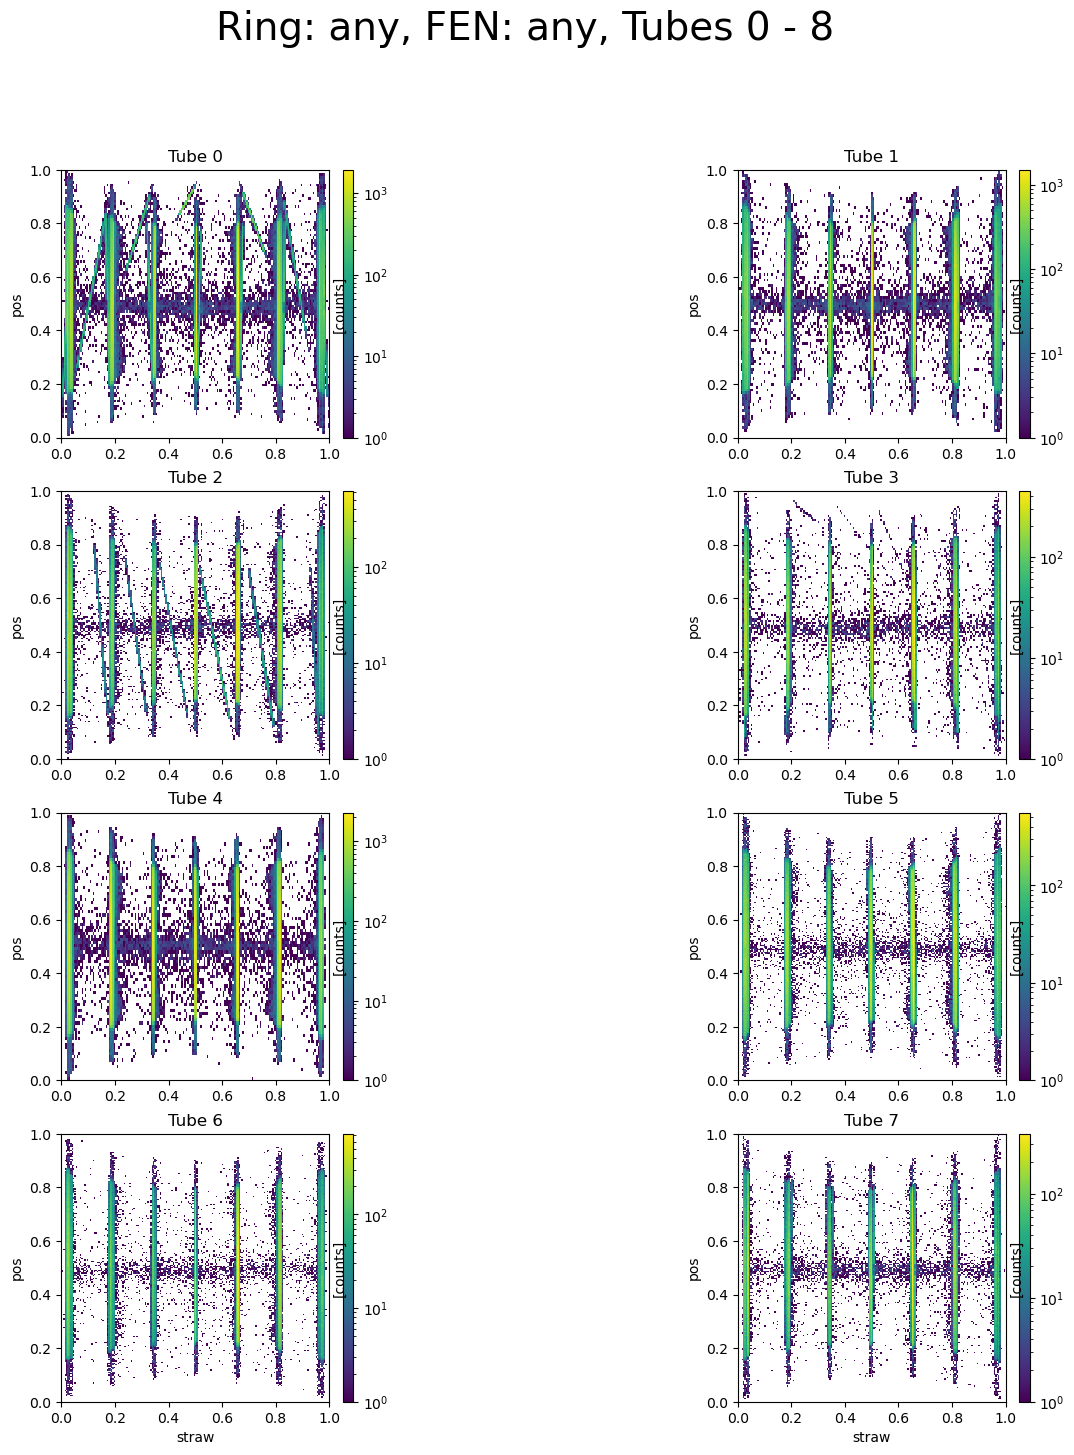

In [52]:
filename = '60383loki_20220304-061312_00000.h5'
filename = f'/Users/wojciechpotrzebowski/SCIPP_SPACE/detector-calibration/data/{filename}'
ring = -1
fen = -1
outdir = filename[:5]
load_and_process_data(filename, ring, fen, outdir)

In [53]:
dat = readtoscipp(filename)

In [56]:
#Bad conf
i = 3
fen = 15

#i = 2
#fen = 1

#Noisy data 
#i = 4
#fen = 7

ring = -1
rgrp = array(dims=['ring'], values=[ring])
fgrp = array(dims=['fen'], values=[fen])
tgrp = array(dims=['tube'], values=[i])

grp = dat.group(fgrp, tgrp).bins.concat()

In [57]:
histogrammed = grp.hist(pos=200, straw=200)

In [58]:
Z = []
X = []
for i in range(200):
    x = histogrammed.coords['straw'][i].value
    z = histogrammed['straw', i].values.sum()
    X.append(x)
    Z.append(z)

In [62]:
Z = flatten_image(histogrammed, 200, 200, 0)

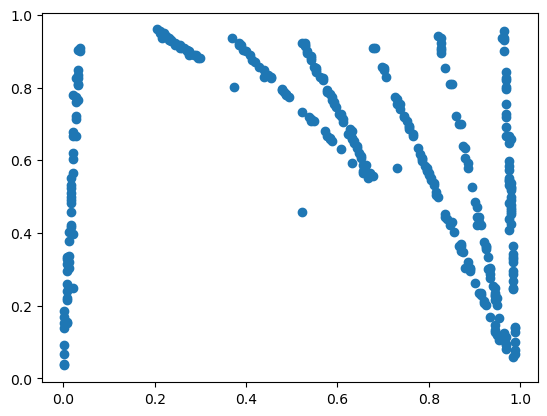

In [63]:
plt.scatter(Z[:, 0], Z[:, 1])

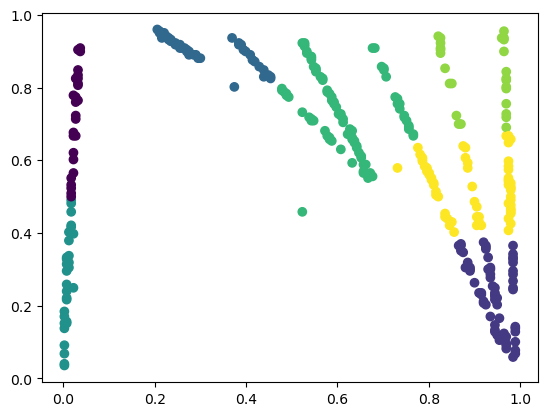

In [64]:
cluster_kmeans(Z)

Estimated number of clusters: 5
Estimated number of noise points: 319
[0.00233864 0.00218853]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


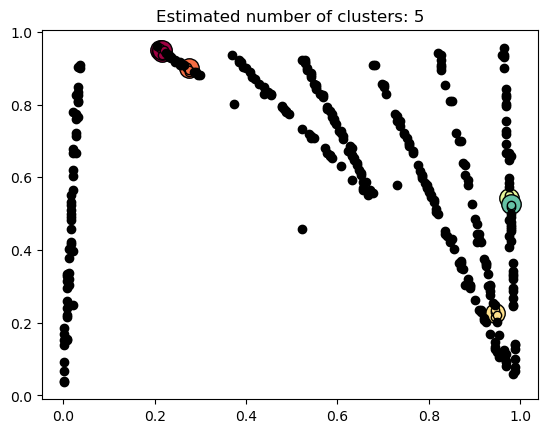

Estimated number of clusters: 26
Estimated number of noise points: 142
[0.00248051 0.00761086]
[0.00214818 0.00734057]
[0.00248051 0.        ]
[0.02525597 0.02169936]
[0.00496101 0.00232129]
[0.00411345 0.00519056]
[0.00543452 0.0119631 ]
[0.00248051 0.00696387]
[0. 0.]
[0.00371248 0.01000043]
[0.00405065 0.00579032]
[0.00708574 0.01783622]
[0.00672945 0.0062975 ]
[0. 0.]
[0. 0.]
[0.00870144 0.02329979]
[0. 0.]
[0. 0.]
[0.         0.00696387]
[0.00467729 0.00218853]
[0. 0.]
[0. 0.]
[0.00198441 0.0065656 ]
[0.00806069 0.00809462]
[0.00184886 0.00981796]
[0.00248051 0.01063749]


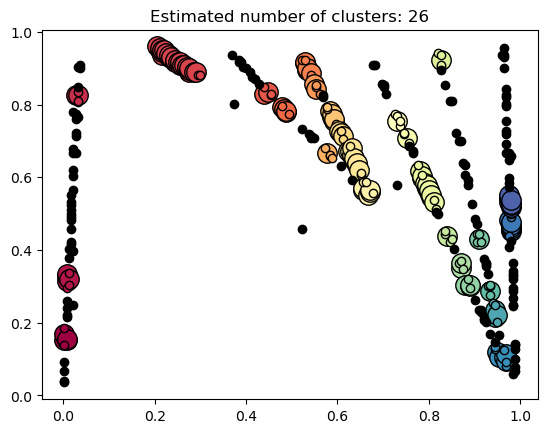

Estimated number of clusters: 26
Estimated number of noise points: 47
[0.00248051 0.00761086]
[0. 0.]
[0.00248051 0.01118617]
[0.00496101 0.00232129]
[0.         0.01517741]
[0.00378904 0.01812986]
[0.02784531 0.02351648]
[0.02573011 0.0359861 ]
[0.00548461 0.00792872]
[0.04659392 0.11580485]
[0.00248051 0.00232129]
[0.00233864 0.00379065]
[0.0118889  0.03295543]
[0.01021535 0.02851148]
[0.         0.00696387]
[0.00554658 0.00891509]
[0.0091611  0.02865266]
[0.00371248 0.01042257]
[0.01234675 0.03322572]
[0.         0.00232129]
[0.01567208 0.0196325 ]
[0.00248051 0.        ]
[0.         0.00232129]
[0.00241848 0.03850203]
[0. 0.]
[0.         0.01160645]


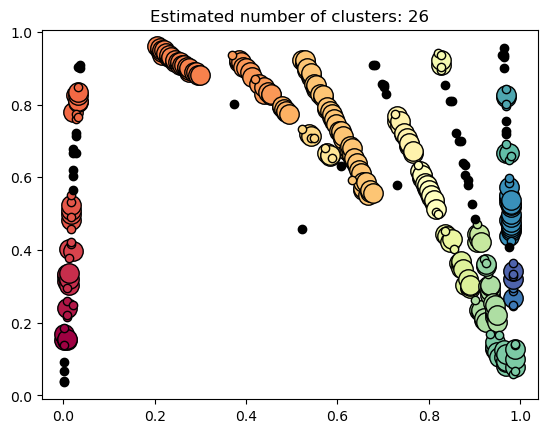

Estimated number of clusters: 16
Estimated number of noise points: 31
[0.00464469 0.06955509]
[0.00350797 0.00957093]
[0.         0.01771226]
[0.00339797 0.0283197 ]
[0.02784531 0.02351648]
[0.03712151 0.04970165]
[0.04563177 0.10785546]
[0.02874625 0.08448494]
[0.00198441 0.01468113]
[0.04444043 0.10535384]
[0. 0.]
[0.00371248 0.01042257]
[0.00233864 0.00218853]
[0.00411345 0.01200581]
[0.         0.00232129]
[0.00243039 0.04423871]


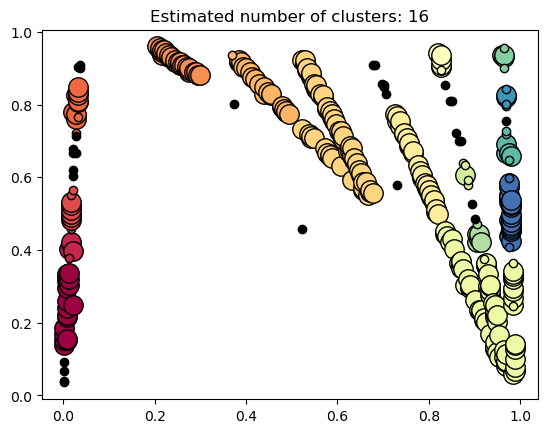

Estimated number of clusters: 11
Estimated number of noise points: 20
[0.00606806 0.13163279]
[0.00371248 0.06025746]
[0.02784531 0.02351648]
[0.03909019 0.05212223]
[0.04563177 0.10785546]
[0.08046751 0.1852001 ]
[0.00184886 0.01695231]
[0.00248051 0.00696387]
[0.00233864 0.00218853]
[0.00371248 0.01389676]
[0.         0.02778016]


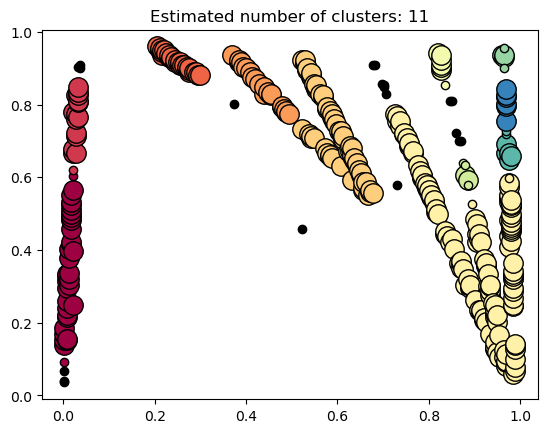

Estimated number of clusters: 5
Estimated number of noise points: 6
[0.00937051 0.22987695]
[0.02784531 0.02351648]
[0.18715827 0.24144388]
[0.00413249 0.02763353]
[0.00248051 0.02059941]


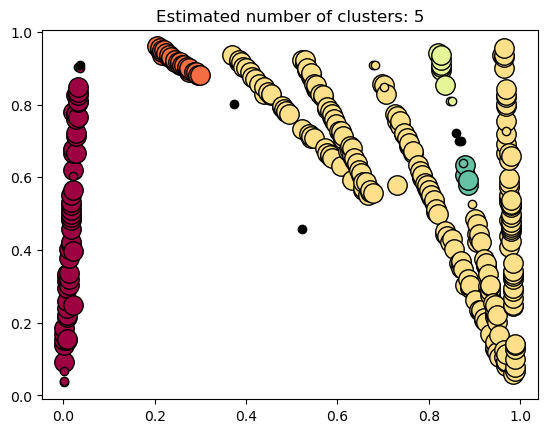

Estimated number of clusters: 4
Estimated number of noise points: 2
[0.00987334 0.24304012]
[0.02784531 0.02351648]
[0.18408774 0.23896632]
[0.00413249 0.02763353]


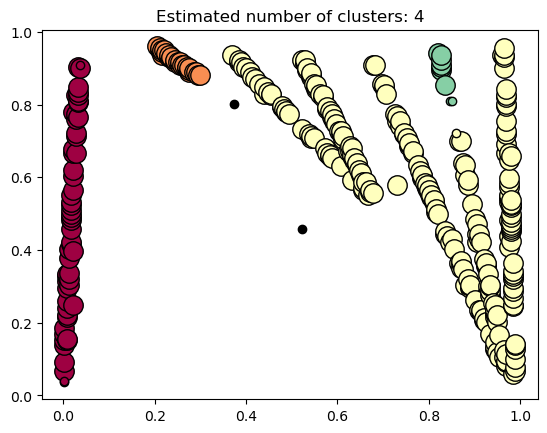

Estimated number of clusters: 4
Estimated number of noise points: 1
[0.01013412 0.24748408]
[0.02784531 0.02351648]
[0.18408774 0.23896632]
[0.00413249 0.02763353]


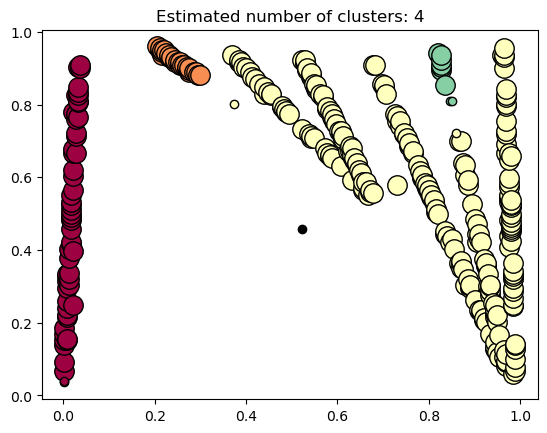

Estimated number of clusters: 2
Estimated number of noise points: 1
[0.01013412 0.24748408]
[0.23531097 0.25136867]


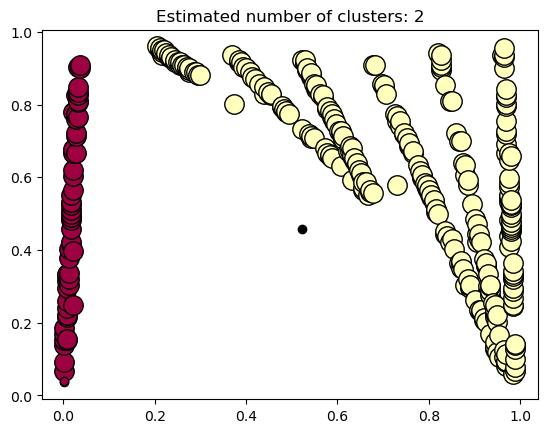

Estimated number of clusters: 2
Estimated number of noise points: 1
[0.01025113 0.25253854]
[0.23531097 0.25136867]


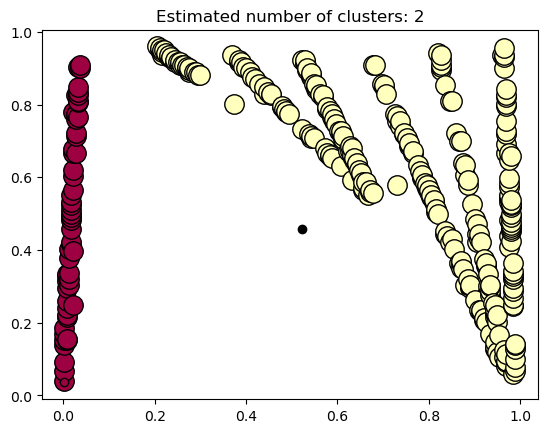

In [66]:
for eps in np.linspace(0.01, 0.1, 10):
    cluster_data(Z, eps=eps, min_samples=5)

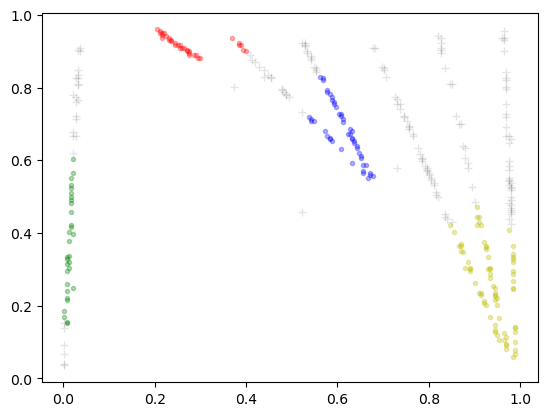

In [67]:
cluster_optics(Z, 20)

In [ ]:
Z = []
X = []
for i in range(200):
    x = histogrammed.coords['pos'][i].value
    z = histogrammed['pos', i].values.sum()
    X.append(x)
    Z.append(z)
Y = np.array([X, Z]).transpose()
plt.scatter(Y[:, 0], Y[:, 1])

In [ ]:
Z = []
X = []
for i in range(200):
    x = histogrammed.coords['straw'][i].value
    z = histogrammed['straw', i].values.sum()
    X.append(x)
    Z.append(z)
Y = np.array([X, Z]).transpose()
plt.scatter(Y[:, 0], Y[:, 1])

In [ ]:
#Idea for algorithm - take slices and calculate PCA. We will loose count information
# From all counts extract slices
# Turn data in slice to X,Y array (we will loose information about counts)
# Run PCA on selected subset 
# Repeat for all slices and compare results 
# Run it for non-zero bins only

In [ ]:
#X = np.array([histogrammed.coords['straw'].values, histogrammed.coords['pos'].values]).transpose()

In [ ]:
histogrammed.plot(aspect=1.,norm='log')

In [ ]:
straw_lens=[(0,25),(29,54),(57,82),(86,111),(114,140),(143,168),(171,200)]
straw1 = histogrammed['straw', :25]
straw2 = histogrammed['straw', 29:54]
straw3 = histogrammed['straw', 57:82]
straw4 = histogrammed['straw', 86:111]
straw5 = histogrammed['straw', 114:140]
straw6 = histogrammed['straw', 143:168]
straw7 = histogrammed['straw', 171:]

In [ ]:
pos1 = histogrammed['pos', :25]
pos2 = histogrammed['pos', 29:54]
pos3 = histogrammed['pos', 57:82]
pos4 = histogrammed['pos', 86:111]
pos5 = histogrammed['pos', 114:140]
pos6 = histogrammed['pos', 143:168]
pos7 = histogrammed['pos', 171:]

In [ ]:
straws = [straw1, straw2, straw3, straw4, straw5, straw6, straw7]

In [ ]:
straw_len = 25
pos_len = 200
for straw in straws:
    Z = flatten_image(straw, straw_len, pos_len)
    pca = PCA(n_components=2).fit(Z)
    print(pca.components_)
    plot_pca(Z, pca)

In [ ]:
all_counts = histogrammed.values.sum()

In [ ]:
straw1.plot(aspect=1.,norm='log')

In [ ]:
rates_straw = [straw1.values.sum()/all_counts,
straw2.values.sum()/all_counts,
straw3.values.sum()/all_counts,
straw4.values.sum()/all_counts,
straw5.values.sum()/all_counts,
straw6.values.sum()/all_counts,
straw7.values.sum()/all_counts]

In [ ]:
rates_pos = [pos1.values.sum()/all_counts,
pos2.values.sum()/all_counts,
pos3.values.sum()/all_counts,
pos4.values.sum()/all_counts,
pos5.values.sum()/all_counts,
pos6.values.sum()/all_counts,
pos7.values.sum()/all_counts]

In [ ]:
rates_pos

In [ ]:
plt.plot(rates_pos)

In [ ]:
plt.plot(rates_straw)